# A. Latihan Teks Clustering

## 1. Preprocessing Data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re
import string
# Membaca Data
# Baca file sebagai teks mentah dulu
with open("data_text.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Hapus koma di setiap baris
cleaned_lines = [line.replace(",", "") for line in lines]

# Simpan kembali ke dataframe
data = pd.DataFrame(cleaned_lines[1:], columns=["text"])  # [1:] untuk skip header "text"

print("Data:", data.shape)
#data

# Preprocessing
# Inisialisasi stemmer & stopword
stemmer = StemmerFactory().create_stemmer()
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

# Kamus normalisasi slang (bisa diperluas sesuai kebutuhan)
normalisasi_dict = {
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "yg": "yang",
    "dlm": "dalam",
    "tp": "tapi",
    "sm": "sama",
    "dgn": "dengan"
}

def normalize_slang(text):
    tokens = text.split()
    tokens = [normalisasi_dict.get(t, t) for t in tokens]
    return " ".join(tokens)

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Hapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    # Hapus emoji & karakter non-ASCII
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Normalisasi huruf berulang (contoh: "hebatttt" -> "hebat")
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    # Normalisasi slang
    text = normalize_slang(text)
    # Tokenisasi sederhana
    tokens = text.split()
    # Buang kata terlalu pendek (<2 huruf)
    tokens = [t for t in tokens if len(t) > 1]
    # Gabungkan kembali
    text = " ".join(tokens)
    # Stemming
    text = stemmer.stem(text)
    # Stopword removal
    text = stopword_remover.remove(text)
    return text

# Terapkan ke dataset
data['clean_text'] = data['text'].astype(str).apply(preprocess_text)

# Contoh hasil
for i in range(min(5, len(data))):
    print(f"\nData ke-{i+1}")
    print("Asli :", data['text'].iloc[i])
    print("Bersih:", data['clean_text'].iloc[i])

Data: (83, 1)

Data ke-1
Asli : Baru sadar kalo kucing gua bisa buka pintu sendiri dia geser gemboknya pake kaki terus keluar dengan elegan. Gua sih cuma liatin sambil mikir ini mah alien berbulu.

Bersih: baru sadar kalo kucing gua buka pintu sendiri geser gembok pake kaki terus keluar elegan gua sih cuma liatin mikir mah alien bulu

Data ke-2
Asli : Hari ini gua nyoba masak mie instan pake susu cair ternyata rasanya kayak makan karton yang direndem air kencing. Never again.

Bersih: hari gua nyoba masak mie instan pake susu cair nyata rasa kayak makan karton direndem air kencing never again

Data ke-3
Asli : Ada tukang bakso lewat depan rumah gua teriak "Bakso!" terus dia nggak berhenti. Gua kejar sampe ujung gang ternyata itu tukang sampah bawa gerobak logam.

Bersih: tukang bakso lewat depan rumah gua teriak bakso terus tidak henti gua kejar sampe ujung gang nyata tukang sampah bawa gerobak logam

Data ke-4
Asli : Barusan gua ketiduran di kampus pas bangun tas gua jadi bantal dan a

## 2. Visualisasi Word Cloud

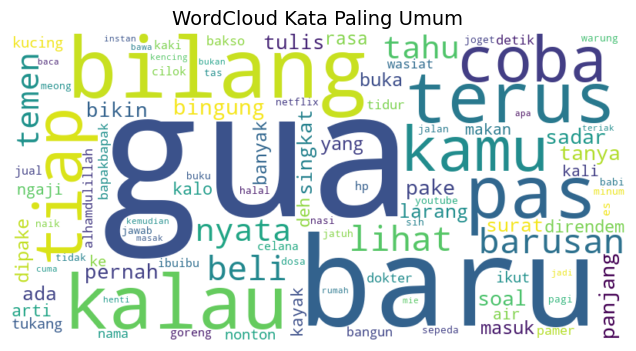

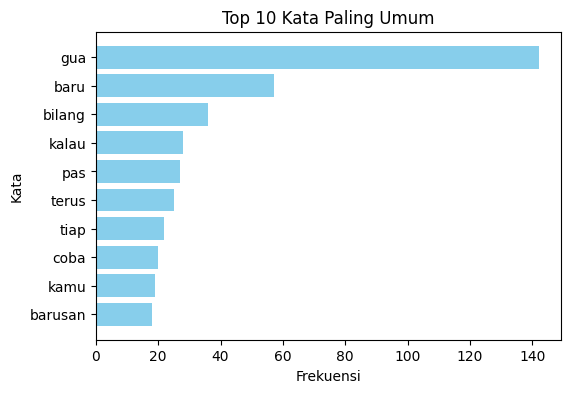

In [57]:
from wordcloud import WordCloud
from collections import Counter
#import matplotlib.pyplot as plt

# Gabungkan semua teks hasil preprocessing
all_words = ' '.join(data['clean_text'])

# Hitung frekuensi kata
word_counts = Counter(all_words.split())

# Ambil Top 10 kata
top10 = word_counts.most_common(10)
words, freqs = zip(*top10)

# --- Visualisasi WordCloud ---
wc = WordCloud(width=800, height=400,
               background_color='white',
               max_words=100,
               colormap='viridis').generate_from_frequencies(word_counts)

# Tampilkan WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Kata Paling Umum", fontsize=14)
plt.show()

# Tampilkan Bar Chart Top 10
plt.figure(figsize=(6, 4))
plt.barh(words, freqs, color='skyblue')
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.title("Top 10 Kata Paling Umum")
plt.gca().invert_yaxis()  # supaya kata frekuensi tertinggi di atas
plt.show()

## 3. TF-IDF dan Uji Elbow Method (Untuk menentukan jumlah cluster optimal)

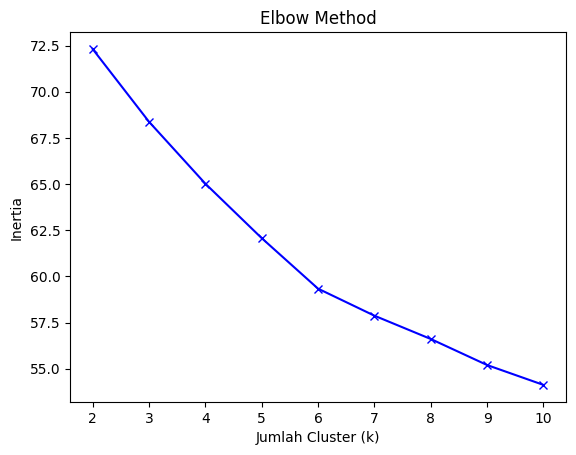

Jumlah cluster = 2, Silhouette Score = 0.039
Jumlah cluster = 3, Silhouette Score = 0.058
Jumlah cluster = 4, Silhouette Score = 0.070
Jumlah cluster = 5, Silhouette Score = 0.085
Jumlah cluster = 6, Silhouette Score = 0.097
Jumlah cluster = 7, Silhouette Score = 0.098
Jumlah cluster = 8, Silhouette Score = 0.097
Jumlah cluster = 9, Silhouette Score = 0.100
Jumlah cluster = 10, Silhouette Score = 0.087
Karena penurunan terjadi di daerah k = 10, maka kita bisa mengambil k = 10 sebagai jumlah cluster


In [59]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # bisa dibatasi fitur
X = vectorizer.fit_transform(data['clean_text'])

# Uji Elbow Method
inertia = []
K = range(2, 11)  # coba cluster dari 2 sampai 10
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Uji Silhouette Score
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Jumlah cluster = {k}, Silhouette Score = {score:.3f}")

print("Karena penurunan terjadi di daerah k = 10, maka kita bisa mengambil k = 10 sebagai jumlah cluster")

## 4. Melakukan Clustering dengan KMeans (K Optimal = 10)

In [60]:
# Clustering dengan k=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Simpan hasil cluster ke dataframe
data['cluster'] = labels

# Lihat jumlah data per cluster
print(data['cluster'].value_counts())

terms = vectorizer.get_feature_names_out()
for i in range(6):
    idx = np.where(labels == i)[0]
    cluster_center = kmeans.cluster_centers_[i]
    top_terms = [terms[t] for t in cluster_center.argsort()[-10:][::-1]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

cluster
2    21
1    15
5    14
3    12
0    12
4     9
Name: count, dtype: int64
Cluster 0: soal, sadar, panjang, ada, gua, tiap, kalau, buka, baru, zonk
Cluster 1: gua, temen, tahu, singkat, tanya, banyak, kalau, pas, bilang, baru
Cluster 2: gua, barusan, lihat, terus, ngaji, bilang, ikut, kucing, tiap, alhamdulillah
Cluster 3: pernah, pake, yang, bikin, direndem, rasa, coba, air, makan, es
Cluster 4: kamu, arti, deh, kalo, kali, coba, ke, dokter, bilang, terus
Cluster 5: baru, tulis, beli, bingung, larang, surat, nyata, gua, masuk, dipake


## 5. Visualisasi per Cluster

### Visualisasi PCA 2D Scatter Plot


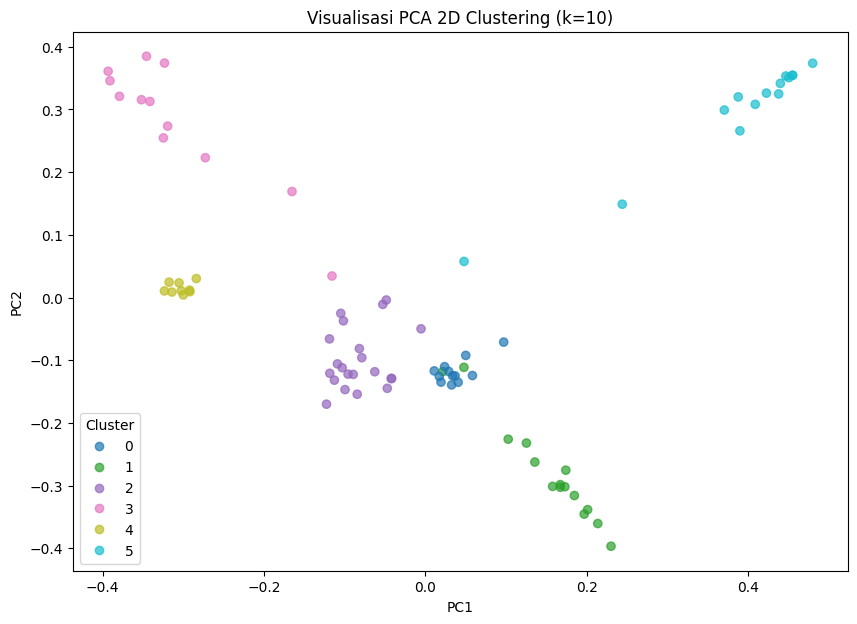

In [61]:
from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt

# Reduksi dimensi ke 2D dengan PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("Visualisasi PCA 2D Clustering (k=10)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Top 10 Kata per Cluster (Bar Chart)

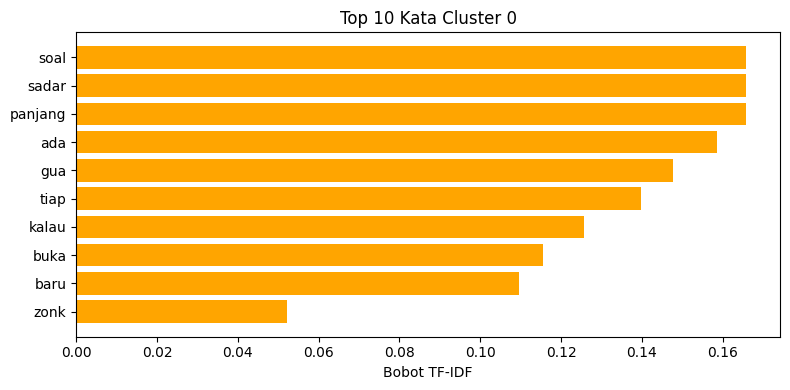

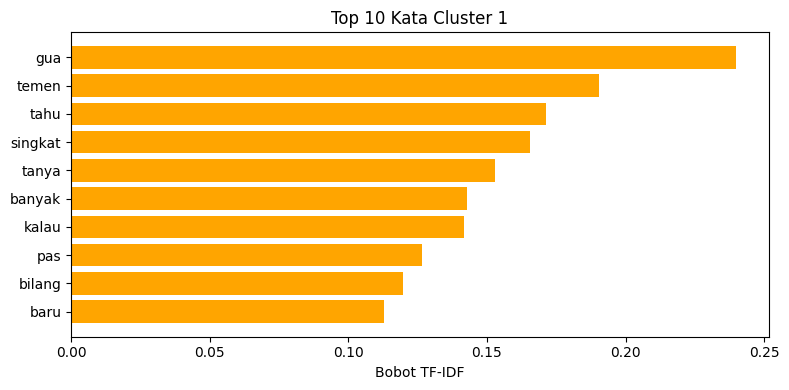

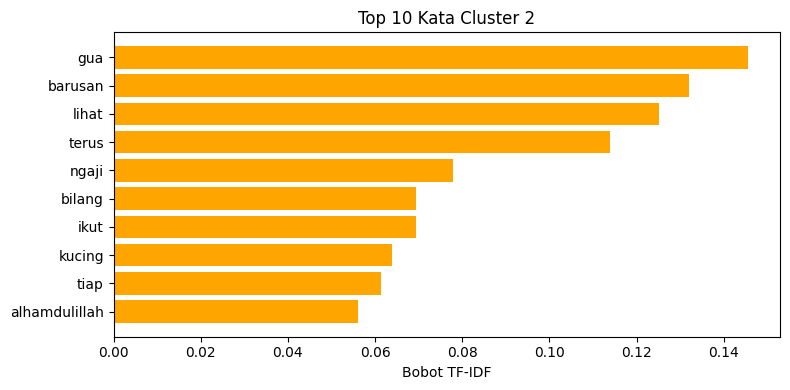

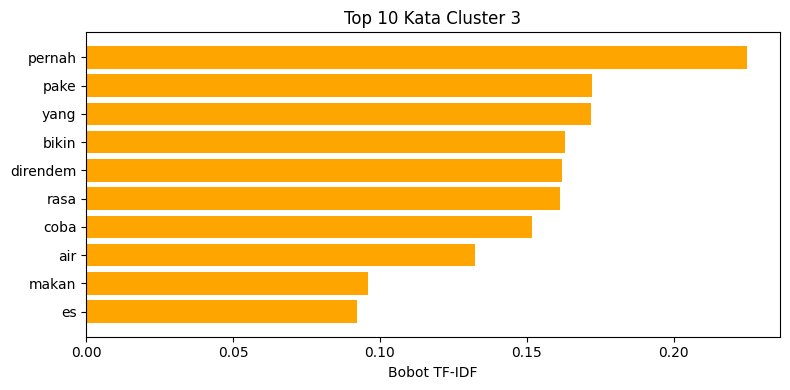

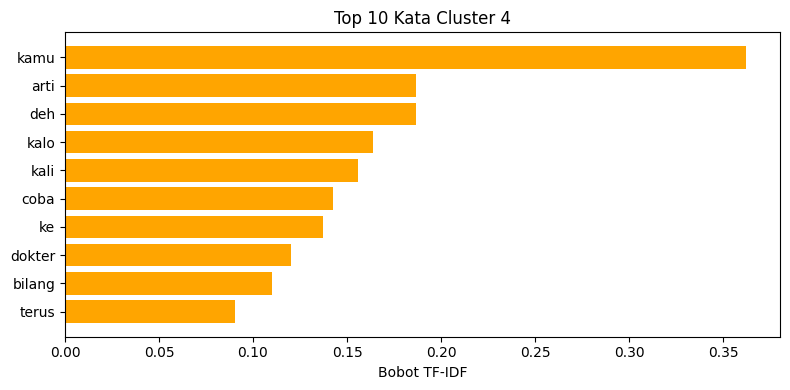

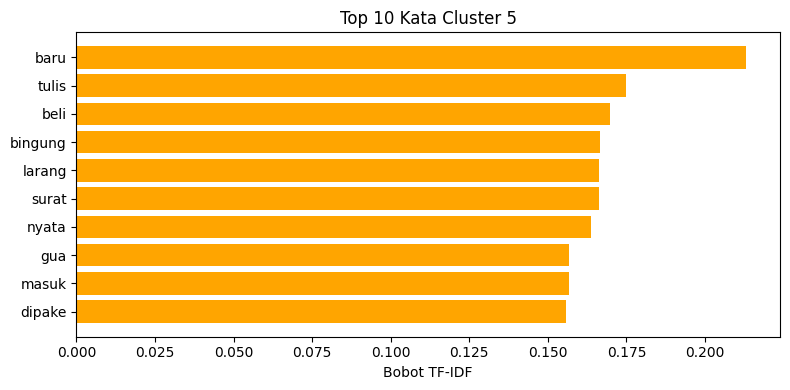

In [63]:
terms = vectorizer.get_feature_names_out()

for i in range(6):
    cluster_center = kmeans.cluster_centers_[i]
    top_idx = cluster_center.argsort()[-10:][::-1]
    top_terms = [terms[j] for j in top_idx]
    top_scores = cluster_center[top_idx]

    plt.figure(figsize=(8,4))
    plt.barh(top_terms[::-1], top_scores[::-1], color='orange')
    plt.title(f"Top 10 Kata Cluster {i}")
    plt.xlabel("Bobot TF-IDF")
    plt.tight_layout()
    plt.show()

### WordCloud per Cluster

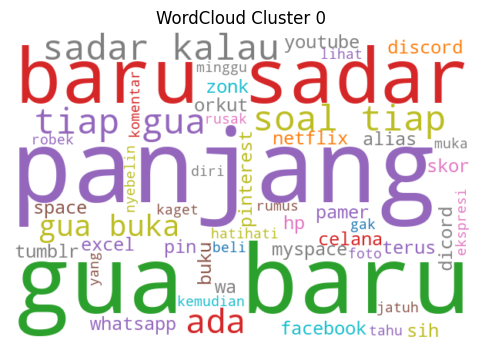

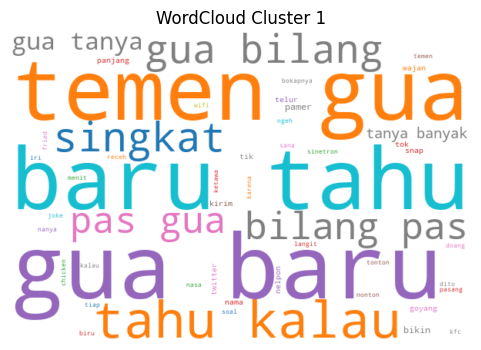

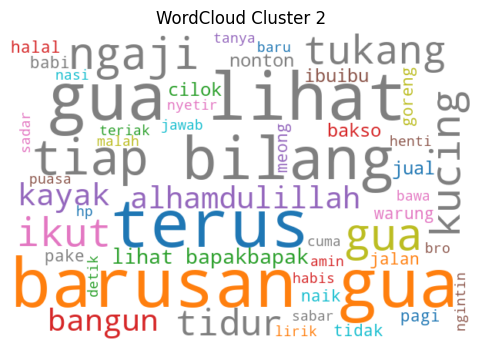

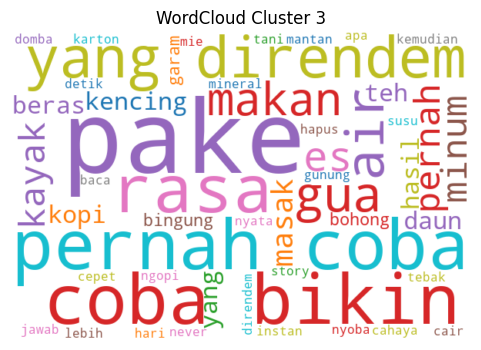

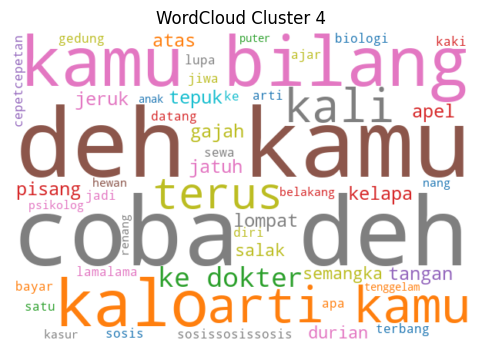

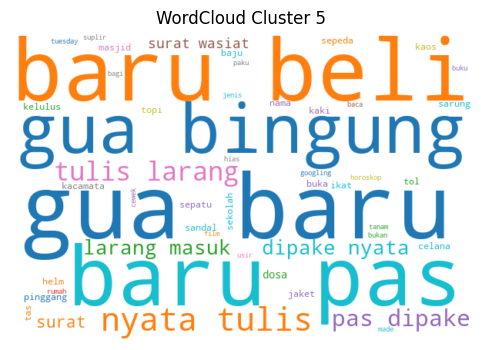

In [64]:
for i in range(6):
    cluster_text = " ".join(data[data['cluster']==i]['clean_text'])
    wc = WordCloud(width=600, height=400,
                   background_color='white',
                   max_words=50,
                   colormap='tab10').generate(cluster_text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Cluster {i}")
    plt.show()

## 6. Sentiment Analysis (Jika data merupakan ulasan atau komentar)

                                                text  \
0  Baru sadar kalo kucing gua bisa buka pintu sen...   
1  Hari ini gua nyoba masak mie instan pake susu ...   
2  Ada tukang bakso lewat depan rumah gua teriak ...   
3  Barusan gua ketiduran di kampus pas bangun tas...   
4  Gua baru ngeh kalau nama temen gua "Dito" itu ...   

                                          clean_text sentiment  
0  baru sadar kalo kucing gua buka pintu sendiri ...    netral  
1  hari gua nyoba masak mie instan pake susu cair...    netral  
2  tukang bakso lewat depan rumah gua teriak baks...    netral  
3  barusan gua tidur kampus pas bangun tas gua ja...    netral  
4  gua baru ngeh kalau nama temen gua dito panjan...    netral  


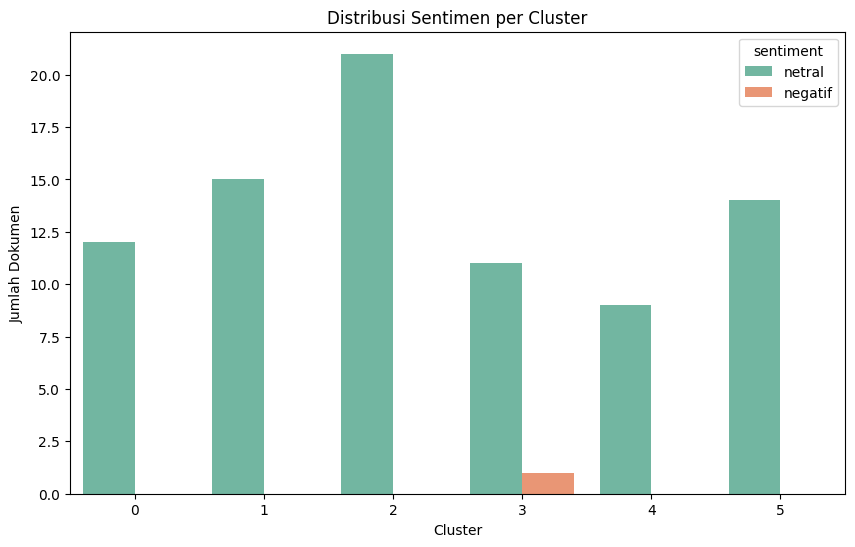

In [66]:
# Kamus kata positif & negatif sederhana
positives = ["bagus", "hebat", "senang", "puas", "baik", "mantap", "suka"]
negatives = ["jelek", "buruk", "parah", "kecewa", "sedih", "marah", "benci"]

def get_sentiment(text):
    score = 0
    for word in text.split():
        if word in positives:
            score += 1
        elif word in negatives:
            score -= 1
    if score > 0:
        return "positif"
    elif score < 0:
        return "negatif"
    else:
        return "netral"

# Tambahkan kolom sentiment
data["sentiment"] = data["clean_text"].apply(get_sentiment)

print(data[["text", "clean_text", "sentiment"]].head())

# Visualisasi distribusi sentimen per cluster
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=data, x="cluster", hue="sentiment", palette="Set2")
plt.title("Distribusi Sentimen per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Dokumen")
plt.show()

## 7. Panduan untuk melakukan interpretasi hasil clustering dan Insight yang dapat dihasilkan

🧭 Panduan Analisis Hasil Text Clustering
1. Preprocessing Teks
Langkah awal untuk memastikan teks bersih dan konsisten:
- Case folding → ubah semua huruf jadi lowercase.
- Tokenisasi → pecah teks jadi kata.
- Stopword removal → buang kata umum yang tidak bermakna (misalnya “dan”, “yang”).
- Stemming/Lemmatization → ubah kata ke bentuk dasar.
- (Opsional) Normalisasi → tangani slang, singkatan, atau typo.
👉 Tujuan: membuat teks lebih representatif dan mengurangi noise.

2. Representasi Fitur
Beberapa opsi umum:
- Bag of Words (BoW) → sederhana, hitung frekuensi kata.
- TF‑IDF → lebih baik, memberi bobot kata penting.
- Word Embeddings (Word2Vec, FastText, GloVe) → menangkap makna semantik.
- Transformer embeddings (BERT, IndoBERT) → paling kuat, cocok untuk teks bahasa Indonesia.
👉 Pilihan tergantung dataset dan tujuan. Untuk clustering awal, TF‑IDF biasanya cukup.

3. Clustering
- KMeans → paling umum, butuh tentukan jumlah cluster.
- Agglomerative Clustering → bisa divisualisasikan dengan dendrogram.
- DBSCAN/HDBSCAN → tidak perlu jumlah cluster, bisa temukan outlier.
👉 Sama seperti image clustering, kamu bisa uji jumlah cluster optimal dengan Elbow dan Silhouette.

4. Evaluasi
- Internal metrics: Silhouette Score, Davies–Bouldin Index, Calinski–Harabasz.
- External metrics (jika ada label ground truth): Adjusted Rand Index (ARI), Normalized Mutual Information (NMI).
- Kualitatif: cek isi cluster → apakah teks dalam cluster punya tema/topik mirip.

5. Interpretasi Cluster
- Top words per cluster: ambil kata dengan bobot TF‑IDF tertinggi di tiap cluster.
- Wordcloud: visualisasi kata dominan.
- Contoh dokumen per cluster: tampilkan beberapa teks representatif.
👉 Dari sini kamu bisa memberi label interpretatif, misalnya:
- Cluster 0 → “Keluhan layanan pelanggan”
- Cluster 1 → “Review positif produk”
- Cluster 2 → “Diskusi teknis”

6. Visualisasi
- PCA/t‑SNE scatter plot → titik = dokumen, warna = cluster.
- Wordcloud per cluster → kata dominan.
- Bar chart distribusi cluster → jumlah dokumen per cluster.

7. Insight yang Bisa Dijabarkan
Beberapa contoh insight:
- Tema dominan: “Cluster 0 berisi 40% dokumen, mayoritas tentang keluhan pengiriman.”
- Sentimen per cluster: gabungkan dengan sentiment analysis → “Cluster 1 dominan positif, cluster 2 dominan negatif.”
- Outlier: dokumen yang tidak cocok dengan cluster → bisa jadi data unik atau noise.
- Keseimbangan dataset: apakah ada cluster yang terlalu kecil atau besar.

8. Langkah Lanjutan
- Coba representasi fitur lebih canggih (BERT embeddings).
- Refinement dengan algoritma lain (HDBSCAN, spectral clustering).
- Gunakan hasil cluster untuk:
- Topic discovery (menemukan tema baru).
- Customer feedback analysis.
- Pre-labeling untuk supervised learning.

✨ Ringkasan
- Preprocessing teks → bersihkan & normalisasi.
- Representasi fitur → TF‑IDF atau embeddings.
- Clustering → KMeans/DBSCAN/Agglomerative.
- Evaluasi → metrik + cek isi cluster.
- Interpretasi → top words, wordcloud, contoh teks.
- Visualisasi → scatter plot, distribusi, wordcloud.
- Insight → tema, sentimen, outlier, keseimbangan.
- Lanjutan → model lebih canggih, aplikasi praktis.


# B. Latihan Image Clustering

## 1. Persiapan Data

Total gambar ditemukan: 1919
Shape array gambar: (50, 128, 128, 3)


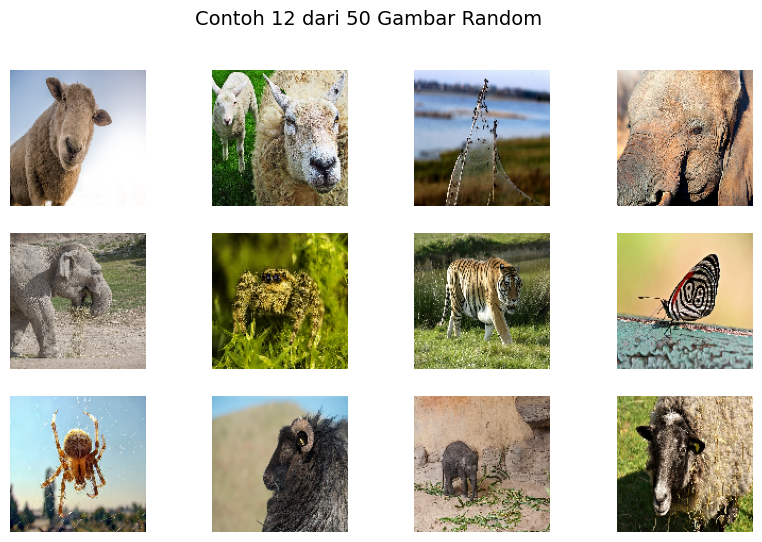

In [ ]:
import os, random
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path utama dataset
base_path = r"C:\Users\adief\OneDrive\Dokumen\Semester 5\Data Mining 2\Week 8 (UTS)\Data Gambar\raw-img"

# Ambil semua path gambar dari semua subfolder
all_images = glob.glob(os.path.join(base_path, "*", "*.jpg"))  # Hapus "*", nya kalau buka folder langsung image

print("Total gambar ditemukan:", len(all_images))

# Ambil 50 gambar random
sample_images = random.sample(all_images, 50)

# Load & resize gambar ke ukuran seragam (misalnya 128x128)
img_array = []
for img_path in sample_images:  # Ubah disini ke all_images jika ingin semua gambar
    img = image.load_img(img_path, target_size=(128,128))
    img = image.img_to_array(img)
    img = img / 255.0  # normalisasi
    img_array.append(img)

img_array = np.array(img_array)
print("Shape array gambar:", img_array.shape)

# Tampilkan beberapa contoh
plt.figure(figsize=(10,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(img_array[i])
    plt.axis("off")
plt.suptitle("Contoh 12 dari 50 Gambar Random", fontsize=14)
plt.show()

Jadi kalau dataset‑mu tidak lagi punya subfolder per hewan, melainkan semua gambar langsung ada di satu folder (misalnya semua file .png ada di raw-img), maka yang perlu diubah hanya bagian path globbing‑nya.
Berikut panduan dengan komentar detail di kode Python:

- Kalau ada subfolder per kelas → gunakan:
all_images = glob.glob(os.path.join(base_path, "*", "*.jpg"))
- Kalau semua gambar langsung ada di 1 folder → gunakan:
all_images = glob.glob(os.path.join(base_path, "*.png"))


Fullnya:
- base_path = r"C:\Users\adief\OneDrive\Dokumen\Semester 5\Data Mining 2\Week 8 (UTS)\Data Gambar\raw-img"
- all_images = glob.glob(os.path.join(base_path, "*.png"))


## 2. Preprocessing Data Gambar

Shape array gambar: (50, 224, 224, 3)


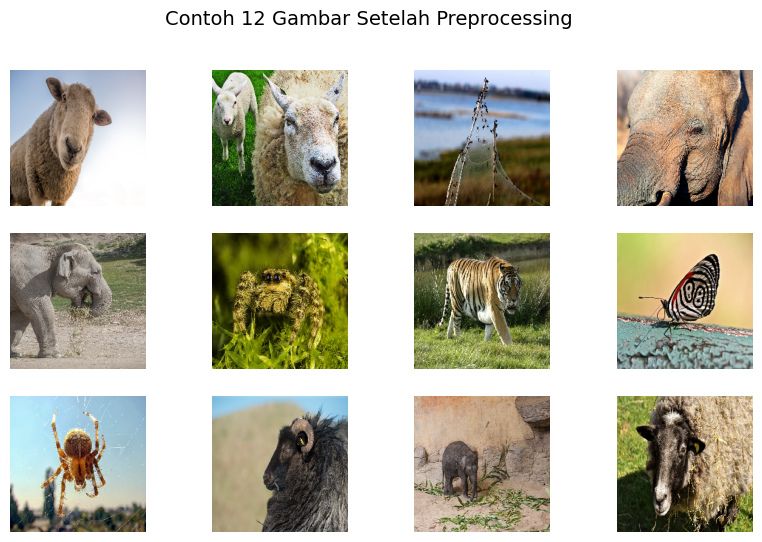

In [2]:
# Misalnya sample_images sudah berisi path 50 gambar random
img_array = []
img_paths = []

for img_path in sample_images:
    try:
        # Resize ke 224x224 (ukuran standar CNN pretrained)
        img = image.load_img(img_path, target_size=(224,224))
        img = image.img_to_array(img)
        img = img / 255.0  # normalisasi pixel
        img_array.append(img)
        img_paths.append(img_path)
    except Exception as e:
        print("Error load:", img_path, e)

# Konversi ke numpy array
img_array = np.array(img_array)
print("Shape array gambar:", img_array.shape)  # (50, 224, 224, 3)

# Tampilkan beberapa contoh hasil preprocessing
plt.figure(figsize=(10,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(img_array[i])
    plt.axis("off")
plt.suptitle("Contoh 12 Gambar Setelah Preprocessing", fontsize=14)
plt.show()

## 3. Feature Extraction menggunakan Pretrained Model (VGG16)

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# 1. Load model VGG16 tanpa fully connected terakhir (hanya feature extractor)
base_model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc1").output)
# "fc1" menghasilkan vektor 4096 dimensi

print(model.summary())  # opsional, untuk lihat arsitektur

# 2. Preprocessing gambar sesuai VGG16
img_preprocessed = preprocess_input(img_array.copy()*255)  # karena sebelumnya sudah dinormalisasi 0-1

# 3. Ekstraksi fitur
features = model.predict(img_preprocessed, verbose=1)

print("Shape fitur:", features.shape)  # (50, 4096)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,479,232 (448.15 MB)

 Trainable params: 117,479,232 (448.15 MB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Shape fitur: (50, 4096)


## 4. Uji nilai k optimal menggunakan Elbow Method

Cluster = 2 | Inertia = 4126967.75 | Silhouette Score = 0.0825
Cluster = 3 | Inertia = 3784008.25 | Silhouette Score = 0.0720
Cluster = 4 | Inertia = 3562469.75 | Silhouette Score = 0.0761
Cluster = 5 | Inertia = 3375577.00 | Silhouette Score = 0.0838
Cluster = 6 | Inertia = 3252147.25 | Silhouette Score = 0.0450
Cluster = 7 | Inertia = 3104186.50 | Silhouette Score = 0.0626
Cluster = 8 | Inertia = 2930102.00 | Silhouette Score = 0.0668
Cluster = 9 | Inertia = 2845302.00 | Silhouette Score = 0.0456
Cluster = 10 | Inertia = 2594953.75 | Silhouette Score = 0.0800


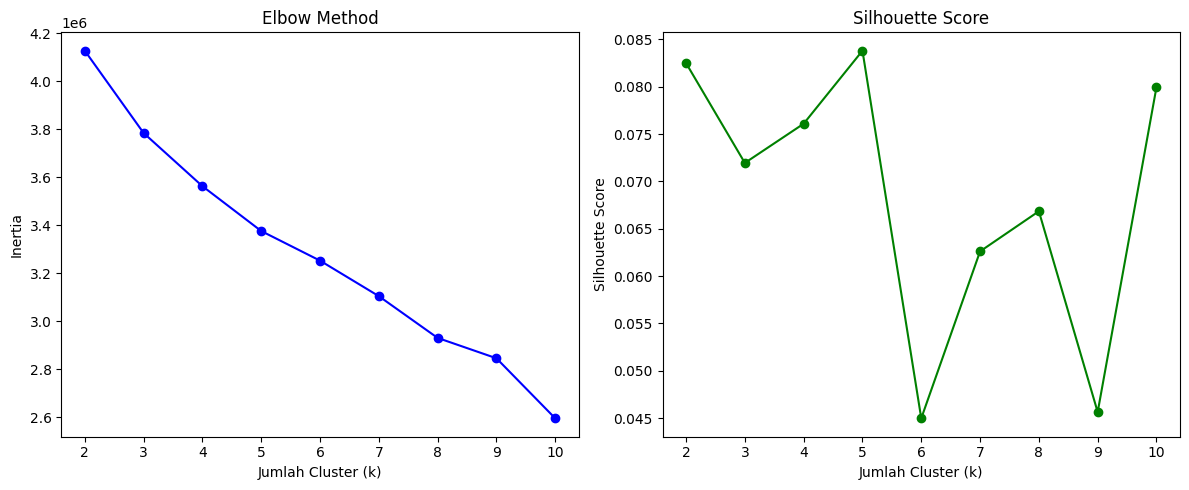

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = features  # hasil ekstraksi fitur VGG16

inertias = []
sil_scores = []
K = range(2, 11)  # coba k=2 sampai 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X, labels)
    
    inertias.append(inertia)
    sil_scores.append(sil)
    
    # Print hasil tiap k
    print(f"Cluster = {k} | Inertia = {inertia:.2f} | Silhouette Score = {sil:.4f}")

# Plot Elbow Method
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, 'o-', color='blue')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(K, sil_scores, 'o-', color='green')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.tight_layout()
plt.show()

## 5. Clustering menggunakan KMeans dengan k optimal

Label cluster untuk 50 gambar: [0 0 3 2 2 3 3 3 1 3 2 3 3 3 3 1 3 3 2 2 3 3 3 2 3 2 4 3 0 2 3 3 2 4 4 0 2
 2 2 1 4 0 0 2 2 2 3 3 3 1]


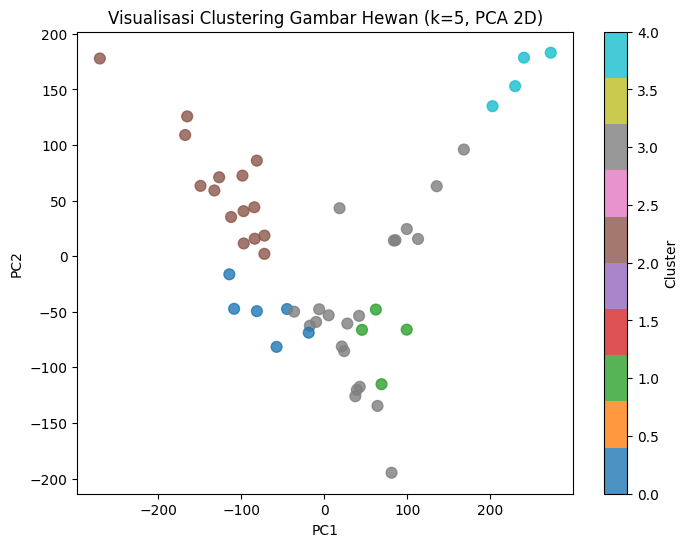

In [11]:
from sklearn.decomposition import PCA

# 1. Jalankan KMeans dengan k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(features)

print("Label cluster untuk 50 gambar:", labels)

# 2. Reduksi dimensi ke 2D dengan PCA untuk visualisasi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(features)

# 3. Plot hasil clustering
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=60, alpha=0.8)
plt.title("Visualisasi Clustering Gambar Hewan (k=5, PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# 4. Fungsi untuk menampilkan contoh gambar dari setiap cluster
def view_cluster(cluster_id, n_images=5):
    """
    Menampilkan contoh gambar dari cluster tertentu.
    cluster_id : nomor cluster (misal 0,1,2,...)
    n_images   : jumlah gambar yang ingin ditampilkan
    """
    idx = np.where(labels == cluster_id)[0]  # ambil index gambar di cluster tsb
    print(f"Cluster {cluster_id} berisi {len(idx)} gambar")

    # tampilkan beberapa contoh
    plt.figure(figsize=(12,3))
    for i, j in enumerate(idx[:n_images]):
        plt.subplot(1, n_images, i+1)
        plt.imshow(img_array[j])
        plt.axis("off")
    plt.suptitle(f"Contoh {n_images} gambar dari Cluster {cluster_id}", fontsize=14)
    plt.show()

In [8]:
for c in range(5):
    idx = np.where(labels == c)[0]
    print(f"Cluster {c} berisi {len(idx)} gambar")

Cluster 0 berisi 6 gambar
Cluster 1 berisi 4 gambar
Cluster 2 berisi 15 gambar
Cluster 3 berisi 21 gambar
Cluster 4 berisi 4 gambar


Cluster 0 berisi 6 gambar


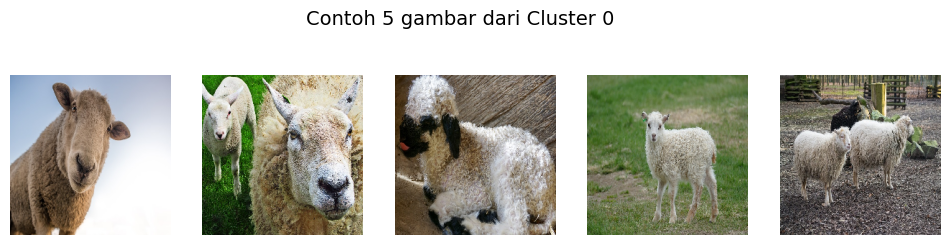

Cluster 1 berisi 4 gambar


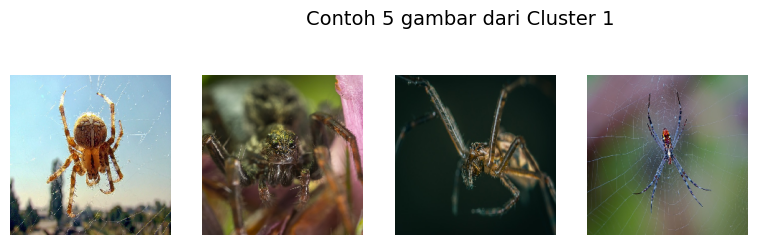

Cluster 2 berisi 15 gambar


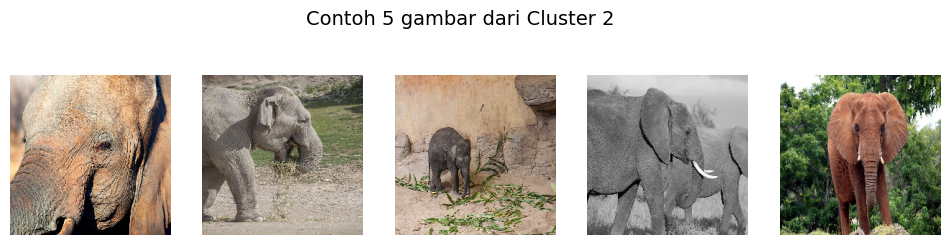

Cluster 3 berisi 21 gambar


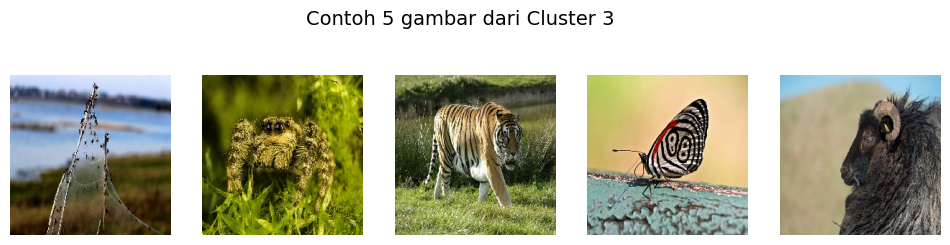

Cluster 4 berisi 4 gambar


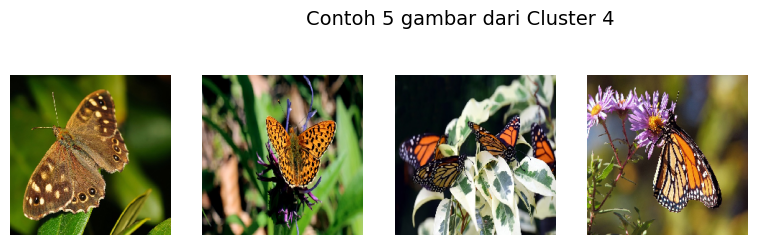

In [ ]:
view_cluster(0)
view_cluster(1)
view_cluster(2)
view_cluster(3)
view_cluster(4)

## 6. Evaluasi Hasil Clustering dan Visualisasi Clustering (Opsional)

In [14]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# labels = hasil KMeans
db_index = davies_bouldin_score(features, labels)
ch_index = calinski_harabasz_score(features, labels)

print(f"Davies-Bouldin Index : {db_index:.4f} (lebih kecil lebih baik)")
print(f"Calinski-Harabasz Score : {ch_index:.4f} (lebih besar lebih baik)")

Davies-Bouldin Index : 2.2054 (lebih kecil lebih baik)
Calinski-Harabasz Score : 4.0846 (lebih besar lebih baik)


C:\Users\adief\AppData\Local\Temp\ipykernel_37944\3887832130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clusters, x="cluster", palette="Set2")


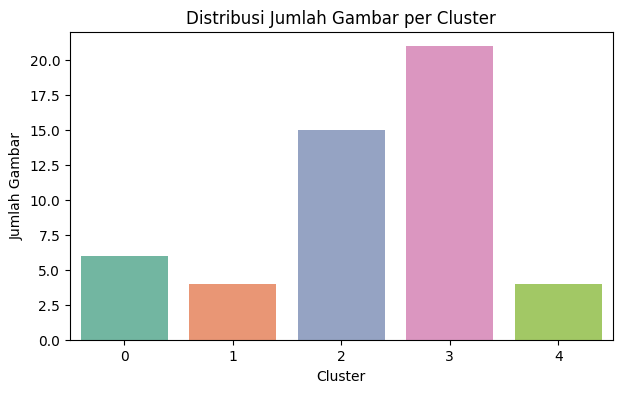

In [15]:
import seaborn as sns
import pandas as pd

df_clusters = pd.DataFrame({"cluster": labels})
plt.figure(figsize=(7,4))
sns.countplot(data=df_clusters, x="cluster", palette="Set2")
plt.title("Distribusi Jumlah Gambar per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Gambar")
plt.show()

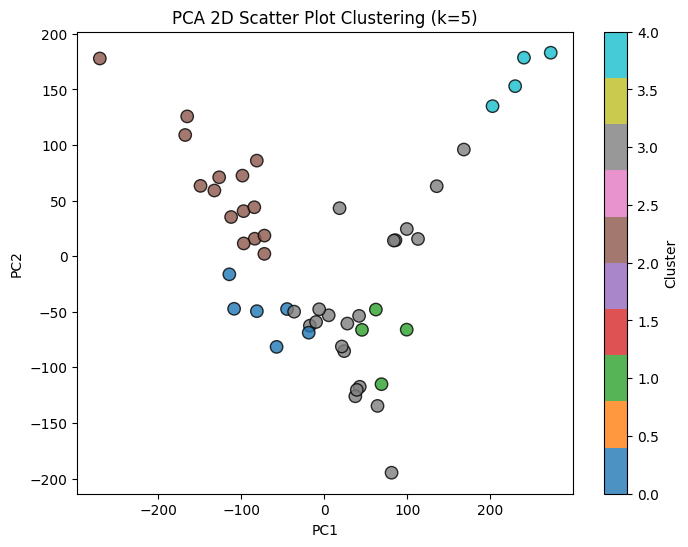

In [20]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=80, alpha=0.8, edgecolors="k")
plt.title("PCA 2D Scatter Plot Clustering (k=5)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

## 7. Panduan untuk melakukan interpretasi hasil clustering dan Insight yang dapat dihasilkan

🧭 Panduan Analisis Hasil Image Clustering
1. Evaluasi Kuantitatif
Gunakan metrik untuk menilai kualitas cluster:
- Silhouette Score → seberapa baik tiap gambar cocok dengan clusternya dibanding cluster lain.
- Davies–Bouldin Index (DBI) → semakin kecil semakin baik.
- Calinski–Harabasz (CH) → semakin besar semakin baik.
- Distribusi cluster → apakah seimbang atau ada cluster yang terlalu kecil/besar.
👉 Tujuan: memastikan cluster tidak asal terbentuk, tapi punya struktur yang cukup jelas.

2. Evaluasi Kualitatif (Visual)
- Lihat isi cluster dengan fungsi view_cluster(c).
- Catat pola visual dominan: warna, bentuk, tekstur, jenis hewan.
- Perhatikan apakah ada outlier (gambar yang “nyasar” ke cluster yang salah).
👉 Tujuan: memahami karakter visual tiap cluster.

3. Labeling / Interpretasi Cluster
Setelah melihat isi cluster, beri label interpretatif:
- Contoh:
- Cluster 0 → “Kucing & Anjing kecil”
- Cluster 1 → “Hewan besar (Gajah, Sapi, Kuda)”
- Cluster 2 → “Burung & Ayam”
- Cluster 3 → “Serangga (Kupu-kupu, Laba-laba)”
- Cluster 4 → “Mamalia kecil (Tupai, Kelinci)”
👉 Tujuan: membuat hasil clustering bisa dipahami orang non-teknis.

4. Visualisasi Kaya
- PCA / t-SNE scatter plot → lihat sebaran cluster di ruang 2D.
- Thumbnail scatter plot → tampilkan gambar kecil di titik scatter (lebih intuitif).
- Bar chart distribusi cluster → berapa banyak gambar per cluster.
👉 Tujuan: menyampaikan hasil dengan cara visual yang mudah dicerna.

5. Insight yang Bisa Dijabarkan
Beberapa contoh insight yang bisa kamu tulis:
- Dominasi kategori: “Cluster 0 didominasi kucing (70%), artinya fitur CNN menangkap pola wajah kucing dengan baik.”
- Kedekatan antar cluster: “Cluster 1 (anjing) dan Cluster 0 (kucing) berdekatan di PCA plot → wajar karena keduanya mamalia kecil dengan bentuk tubuh mirip.”
- Outlier: “Ada beberapa gambar sapi yang masuk cluster gajah → kemungkinan karena ukuran tubuh besar dan warna kulit mirip.”
- Keseimbangan dataset: “Cluster serangga relatif kecil (hanya 5 gambar), menunjukkan dataset tidak seimbang.”

✨ Ringkasan
- Ukur kualitas cluster (Silhouette, DBI, CH).
- Lihat isi cluster → catat pola visual.
- Beri label interpretatif → komunikasikan hasil.
- Visualisasikan → PCA/t-SNE + distribusi.
- Jabarkan insight → dominasi, kedekatan, outlier, keseimbangan.
- Gunakan hasil → retrieval, cleaning, pseudo-labeling.
